In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_privacy
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras import layers
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
tf.random.set_seed(42)

from ctgan import CTGANSynthesizer

D:\Sean\Miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://github.com/sdv-dev/SDGym/issues/44

In [3]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32)/255
test_data = np.array(test_data, dtype=np.float32)/255

train_data = train_data.reshape(train_data.shape[0],28,28,1) 
test_data = test_data.reshape(test_data.shape[0],28,28,1)

train_labels = np.array(train_labels, dtype = np.int32)
test_labels = np.array(test_labels, dtype = np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = 10)

#check data distribution, normalized since divided by 255
assert train_data.min() == 0
assert train_data.max() == 1
assert test_data.min() == 0
assert test_data.max() == 1

## Defining Functions

In [4]:
def dp_sgd(l2_norm_clip,noise_multiplier,num_microbatches,learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,8,
                              strides = 2,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28,28,1)),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Conv2D(32,4,
                               strides = 2,
                               padding = 'valid',
                               activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip = l2_norm_clip,
        noise_multiplier = noise_multiplier,
        num_microbatches = num_microbatches,
        learning_rate = learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False, reduction = tf.losses.Reduction.NONE)
    model.compile(optimizer = optimizer , loss = loss, metrics = ['accuracy'])
    return model

def getlayeroutput(model,data,index):
    from keras import backend as K
    getoutput = K.function([model.layers[0].input],[model.layers[index].output])
    return getoutput([data])[0]

def discriminatortrue(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20,input_dim = in_shape,
                              activation = 'linear'),
        tf.keras.layers.Dense(30,activation = 'relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(10,activation = 'linear'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model


def train(distrue, gan, output_noise, output_true):
    
    ### HUGE NOTE: Normalmodel is 1, DPmodel is 0
    
    #train the true discriminator to the DPmodel and Normalmodel data
    distrue_output_true_train_x = output_true[:] #setting x data from normalmodel for true discriminant
    distrue_output_true_train_y = np.ones((output_true.shape[0],1)) #setting y data from normalmodel for true discriminant
    
    distrue_output_noise_train_x = output_noise[:] #setting x data from DPmodel for true discriminant
    distrue_output_noise_train_y = np.zeros((output_noise.shape[0],1)) #setting y data from DPmodel for true discriminant
    
    #combine
    distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
    distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_shuffle, distruey_shuffle = shuffledata(distruex,distruey)
    distrue.fit(distruex_shuffle,distruey_shuffle)
    
    #Initiate GAN
    ###########################################################################################################      
    ##GAN PART
    gan.fit(output_true)
    fake = gan.sample(output_true.shape[0])
    ########################################################################################################### 
    #final accuracy of True Discriminant
    output_true_upsampled_x = fake[:]
    output_true_upsampled_y = np.ones((output_true_upsampled_x.shape[0],1))
    
    output_noise_x, output_noise_y = output_noise[:], np.zeros((output_noise.shape[0],1))
    
    distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
    distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_final_shuffle, distruey_final_shuffle = shuffledata(distruex_final,distruey_final)
    pred = distrue.predict(distruex_final_shuffle)  

    fin_acc = accuracy_score(np.array(distruey_final_shuffle), pred)
    print("Final True Discriminant Accuracy: %.3f" % fin_acc)
    

def shuffledata(xdata,ydata):
    indices = tf.range(start=0,limit=tf.shape(xdata)[0], dtype = tf.int32)
    idx = tf.random.shuffle(indices)
    return tf.gather(xdata,idx) , tf.gather(ydata,idx)

## Training Original Model 

##### DP Model (1.5 Noise Multiplier) vs DP Model (1.8 Noise Multiplier)

In [5]:
DPmodel1_5 = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1.5, 
                 num_microbatches = 50, learning_rate = 0.25)
DPmodel1_8 = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1.8, 
                 num_microbatches = 50, learning_rate = 0.25)

DPmodel1_5.fit(train_data, train_labels, 
               epochs = 5, batch_size = 250,
               validation_data = (test_data, test_labels))

DPmodel1_8.fit(train_data, train_labels, 
               epochs = 5, batch_size = 250,
               validation_data = (test_data, test_labels))

Epoch 1/5
240/240 [==============================] - 30s 107ms/step - loss: 0.9571 - accuracy: 0.7036 - val_loss: 0.7822 - val_accuracy: 0.8270
Epoch 2/5
240/240 [==============================] - 26s 107ms/step - loss: 0.8830 - accuracy: 0.8291 - val_loss: 0.9845 - val_accuracy: 0.8267
Epoch 3/5
240/240 [==============================] - 26s 109ms/step - loss: 1.0828 - accuracy: 0.8058 - val_loss: 1.1392 - val_accuracy: 0.8117
Epoch 4/5
240/240 [==============================] - 26s 109ms/step - loss: 1.2298 - accuracy: 0.8179 - val_loss: 1.1440 - val_accuracy: 0.8431
Epoch 5/5
240/240 [==============================] - 26s 108ms/step - loss: 1.2556 - accuracy: 0.8135 - val_loss: 1.1243 - val_accuracy: 0.8291
Epoch 1/5
240/240 [==============================] - 31s 120ms/step - loss: 1.1713 - accuracy: 0.6549 - val_loss: 1.1180 - val_accuracy: 0.7806
Epoch 2/5
240/240 [==============================] - 27s 114ms/step - loss: 1.4677 - accuracy: 0.7485 - val_loss: 1.4542 - val_accuracy:

##### DP Model Privacy

In [5]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1,
                                              epochs=5,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 1200 steps satisfies differential privacy with eps = 1.13 and delta = 1e-05.
The optimal RDP order is 10.0.


(1.1278495014370558, 10.0)

##### Normal Model Privacy

In [6]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1,
                                              epochs=5,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 1200 steps satisfies differential privacy with eps = 1.13 and delta = 1e-05.
The optimal RDP order is 10.0.


(1.1278495014370558, 10.0)

## Proceed with GAN

In [7]:
output_model_noise = DPmodel.predict(train_data)
output_model_true = Normalmodel.predict(train_data)

1875/1875 [==============================] - 8s 4ms/step


In [8]:
for i in range(0,5):
    findisc = RandomForestClassifier(random_state = 42)
    gan = CTGANSynthesizer(epochs = 50, verbose = True, cuda = True)
    train(findisc,gan,output_model_noise,output_model_true)

C:\Windows\Temp\ipykernel_3428\1433498633.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:67: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  distrue.fit(distruex_shuffle,distruey_shuffle)
D:\Sean\Miniconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did n

Epoch 1, Loss G: -0.2006,Loss D: -0.1389
Epoch 2, Loss G: -1.2524,Loss D: -0.0397
Epoch 3, Loss G: -1.7764,Loss D:  0.0544
Epoch 4, Loss G: -1.4782,Loss D: -0.1304
Epoch 5, Loss G: -1.7709,Loss D: -0.0077
Epoch 6, Loss G: -2.5538,Loss D:  0.0062
Epoch 7, Loss G: -2.1242,Loss D:  0.0908
Epoch 8, Loss G: -2.4163,Loss D: -0.1830
Epoch 9, Loss G: -2.5487,Loss D:  0.0281
Epoch 10, Loss G: -2.3718,Loss D:  0.0182
Epoch 11, Loss G: -1.9148,Loss D: -0.1422
Epoch 12, Loss G: -1.7986,Loss D: -0.2358
Epoch 13, Loss G: -1.5050,Loss D: -0.2467
Epoch 14, Loss G: -1.0650,Loss D: -0.1383
Epoch 15, Loss G: -0.7710,Loss D: -0.1560
Epoch 16, Loss G: -0.5980,Loss D: -0.4560
Epoch 17, Loss G: -0.5461,Loss D: -0.1825
Epoch 18, Loss G: -0.1355,Loss D:  0.1023
Epoch 19, Loss G: -0.2314,Loss D: -0.0823
Epoch 20, Loss G: -0.1937,Loss D: -0.2138
Epoch 21, Loss G:  0.3902,Loss D: -0.1873
Epoch 22, Loss G:  0.3707,Loss D: -0.0659
Epoch 23, Loss G:  0.1189,Loss D: -0.0944
Epoch 24, Loss G:  0.2543,Loss D: -0.5080
E

C:\Windows\Temp\ipykernel_3428\1433498633.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.730


C:\Windows\Temp\ipykernel_3428\1433498633.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:67: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  distrue.fit(distruex_shuffle,distruey_shuffle)
D:\Sean\Miniconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did n

Epoch 1, Loss G: -0.2980,Loss D: -0.1068
Epoch 2, Loss G: -1.5831,Loss D:  0.0232
Epoch 3, Loss G: -1.2645,Loss D: -0.0401
Epoch 4, Loss G: -1.3055,Loss D: -0.0749
Epoch 5, Loss G: -2.3466,Loss D:  0.0130
Epoch 6, Loss G: -2.1726,Loss D: -0.0594
Epoch 7, Loss G: -1.9438,Loss D:  0.0973
Epoch 8, Loss G: -2.4103,Loss D: -0.0902
Epoch 9, Loss G: -2.3524,Loss D:  0.1346
Epoch 10, Loss G: -2.2868,Loss D: -0.1697
Epoch 11, Loss G: -2.0122,Loss D:  0.0540
Epoch 12, Loss G: -1.6915,Loss D:  0.0080
Epoch 13, Loss G: -1.5780,Loss D: -0.3202
Epoch 14, Loss G: -1.1583,Loss D:  0.0964
Epoch 15, Loss G: -1.0184,Loss D: -0.0925
Epoch 16, Loss G: -0.9779,Loss D: -0.0772
Epoch 17, Loss G: -0.3879,Loss D: -0.2477
Epoch 18, Loss G: -0.2676,Loss D: -0.0068
Epoch 19, Loss G: -0.0396,Loss D: -0.1326
Epoch 20, Loss G: -0.0924,Loss D: -0.0074
Epoch 21, Loss G: -0.0232,Loss D: -0.1364
Epoch 22, Loss G:  0.4458,Loss D: -0.2303
Epoch 23, Loss G:  0.4274,Loss D: -0.5631
Epoch 24, Loss G:  0.2370,Loss D: -0.3273
E

C:\Windows\Temp\ipykernel_3428\1433498633.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.671


C:\Windows\Temp\ipykernel_3428\1433498633.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:67: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  distrue.fit(distruex_shuffle,distruey_shuffle)
D:\Sean\Miniconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did n

Epoch 1, Loss G: -0.1420,Loss D: -0.1146
Epoch 2, Loss G: -2.0836,Loss D:  0.1218
Epoch 3, Loss G: -1.9080,Loss D:  0.0133
Epoch 4, Loss G: -0.9767,Loss D:  0.1081
Epoch 5, Loss G: -1.9078,Loss D: -0.2239
Epoch 6, Loss G: -2.7595,Loss D:  0.0859
Epoch 7, Loss G: -1.5766,Loss D:  0.1533
Epoch 8, Loss G: -1.9760,Loss D: -0.2217
Epoch 9, Loss G: -2.4333,Loss D: -0.0570
Epoch 10, Loss G: -2.2869,Loss D: -0.0057
Epoch 11, Loss G: -2.4442,Loss D: -0.0560
Epoch 12, Loss G: -2.2279,Loss D:  0.0062
Epoch 13, Loss G: -1.7640,Loss D: -0.0036
Epoch 14, Loss G: -1.3252,Loss D: -0.1797
Epoch 15, Loss G: -0.5902,Loss D: -0.0892
Epoch 16, Loss G: -0.5413,Loss D:  0.0713
Epoch 17, Loss G: -0.4796,Loss D: -0.2058
Epoch 18, Loss G: -0.3119,Loss D: -0.0142
Epoch 19, Loss G:  0.6155,Loss D:  0.1816
Epoch 20, Loss G:  0.4049,Loss D:  0.0187
Epoch 21, Loss G: -0.0568,Loss D: -0.1681
Epoch 22, Loss G: -0.1227,Loss D: -0.3635
Epoch 23, Loss G:  0.3149,Loss D: -0.2578
Epoch 24, Loss G:  0.6380,Loss D: -0.2871
E

C:\Windows\Temp\ipykernel_3428\1433498633.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.778


C:\Windows\Temp\ipykernel_3428\1433498633.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:67: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  distrue.fit(distruex_shuffle,distruey_shuffle)
D:\Sean\Miniconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did n

Epoch 1, Loss G: -0.2134,Loss D: -0.3204
Epoch 2, Loss G: -2.0639,Loss D:  0.0715
Epoch 3, Loss G: -1.7568,Loss D:  0.0978
Epoch 4, Loss G: -1.3074,Loss D: -0.0192
Epoch 5, Loss G: -2.1705,Loss D:  0.0221
Epoch 6, Loss G: -2.2506,Loss D:  0.2152
Epoch 7, Loss G: -2.0368,Loss D:  0.1167
Epoch 8, Loss G: -2.7015,Loss D:  0.0791
Epoch 9, Loss G: -2.1045,Loss D:  0.2450
Epoch 10, Loss G: -2.2148,Loss D:  0.1796
Epoch 11, Loss G: -2.2794,Loss D:  0.1540
Epoch 12, Loss G: -1.7913,Loss D:  0.0751
Epoch 13, Loss G: -1.8469,Loss D: -0.0891
Epoch 14, Loss G: -1.5125,Loss D: -0.2451
Epoch 15, Loss G: -1.2249,Loss D: -0.0358
Epoch 16, Loss G: -0.6729,Loss D: -0.0723
Epoch 17, Loss G: -0.6476,Loss D: -0.2647
Epoch 18, Loss G: -0.6234,Loss D: -0.3157
Epoch 19, Loss G: -0.0401,Loss D:  0.2374
Epoch 20, Loss G: -0.2509,Loss D: -0.3263
Epoch 21, Loss G: -0.2752,Loss D: -0.2793
Epoch 22, Loss G:  0.1081,Loss D: -0.3461
Epoch 23, Loss G:  0.0768,Loss D: -0.0991
Epoch 24, Loss G: -0.2502,Loss D: -0.0098
E

C:\Windows\Temp\ipykernel_3428\1433498633.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.626


C:\Windows\Temp\ipykernel_3428\1433498633.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:67: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  distrue.fit(distruex_shuffle,distruey_shuffle)
D:\Sean\Miniconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did n

Epoch 1, Loss G: -0.4816,Loss D: -0.1315
Epoch 2, Loss G: -1.6662,Loss D: -0.0210
Epoch 3, Loss G: -1.7049,Loss D: -0.2090
Epoch 4, Loss G: -1.5472,Loss D:  0.0546
Epoch 5, Loss G: -2.2804,Loss D: -0.0186
Epoch 6, Loss G: -2.7416,Loss D:  0.0605
Epoch 7, Loss G: -2.3385,Loss D: -0.1503
Epoch 8, Loss G: -2.1585,Loss D:  0.0753
Epoch 9, Loss G: -2.3810,Loss D: -0.0564
Epoch 10, Loss G: -2.2881,Loss D:  0.0040
Epoch 11, Loss G: -1.5925,Loss D:  0.2065
Epoch 12, Loss G: -1.6713,Loss D: -0.0324
Epoch 13, Loss G: -1.1866,Loss D: -0.0605
Epoch 14, Loss G: -0.9694,Loss D:  0.0857
Epoch 15, Loss G: -0.9085,Loss D: -0.0650
Epoch 16, Loss G: -0.5229,Loss D: -0.0503
Epoch 17, Loss G: -0.3802,Loss D: -0.0819
Epoch 18, Loss G: -0.2059,Loss D: -0.4052
Epoch 19, Loss G: -0.1912,Loss D: -0.2530
Epoch 20, Loss G: -0.2274,Loss D: -0.1602
Epoch 21, Loss G:  0.1394,Loss D: -0.6018
Epoch 22, Loss G: -0.1660,Loss D: -0.1373
Epoch 23, Loss G:  0.3715,Loss D: -0.0646
Epoch 24, Loss G:  0.4728,Loss D:  0.2552
E

C:\Windows\Temp\ipykernel_3428\1433498633.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_3428\1433498633.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.698


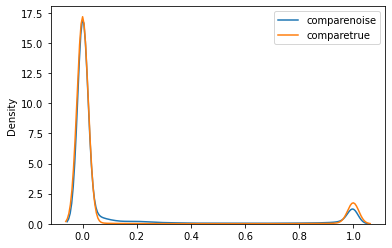

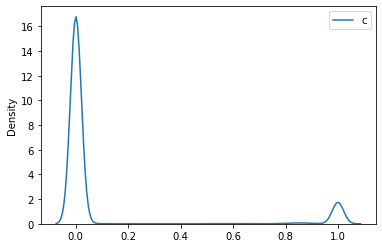

In [9]:
fake = gan.sample(output_model_true.shape[0])
comparenoise = output_model_noise.flatten()
comparetrue = output_model_true.flatten()
comparefake = fake.flatten()
sns.kdeplot(comparenoise)
sns.kdeplot(comparetrue)
plt.legend(labels = ['comparenoise','comparetrue'])
plt.show()
sns.kdeplot(comparefake)
plt.legend(labels = 'comparefake')
plt.show()

In [10]:
from scipy.stats import ttest_ind

ttest_ind(comparetrue,comparefake)

Ttest_indResult(statistic=-7.0370962203591505, pvalue=1.963916376146854e-12)

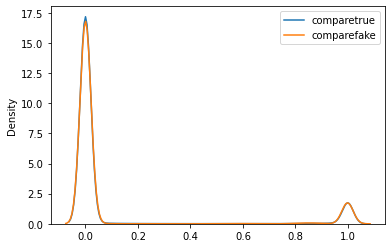

In [11]:
sns.kdeplot(comparetrue)
sns.kdeplot(comparefake)
plt.legend(labels = ['comparetrue','comparefake'])